In [765]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import math
from scipy.optimize import fsolve
from tqdm.notebook import tqdm
np.set_printoptions(threshold=np.inf)

In [766]:
# Parameters
nx, ny = 20, 20 # Mise à jour des valeurs de nx et ny
Lx, Ly = 1, 1   # Mise à jour des valeurs de Lx et Ly
nt = 100
dt = 0.01
dx = 0.005
dy = 0.005
h = 400
T0, T1, Ta = 373.15, 423.15, 298.15  # temperatures in Kelvin (initial, boundary, and ambient)
k = 50  # thermal conductivity of copper in W/(m·K)
rho = 8960.0  # density of copper in kg/m³
cp = 385.0  # thermal capacity of copper in J/(kg·K)
alpha = 0.01  # thermal diffusivity of copper in m²/s
Fx = alpha * dt / dx**2
Fy = alpha * dt / dy**2

In [767]:
# Definition of functions
def equation(x, L, h, l):
    return x * np.tan(L * x) - h / l

def find_first_n_solutions(L, h, l, n):
    solutions = []
    guess = 0.1
    while len(solutions) < n:
        solution = fsolve(equation, guess, args=(L, h, l))
        solution = solution[0]  # Convertir la solution en un nombre réel
        if not any(abs(sol - solution) < 1e-7 for sol in solutions):  # Vérifier si la solution est déjà dans la liste
            solutions.append(solution)
        guess += 0.1  # Augmenter la supposition initiale pour la prochaine solution
        # print(solutions)
    return solutions

def serie(Lx, Ly, h, l, x, y, n, liste_solutions):
    sum = 0
    for k in range(0, n+1):
        a = liste_solutions[k]
        x_k = (np.cos(a*y)*np.cosh(a*(Ly-x)))/(((a**2+(h/l)**2)*Lx+h/l)*np.cos(a*Lx)*np.cosh(a*Ly))
        sum += x_k
    # print("sum =", sum)
    return sum

def generate_analytical_profile(nx, ny, Lx, Ly, T1, Ta, h, k, n, liste_solutions):

    # Créer des grilles de points x et y
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)

    # Initialiser le profil analytique
    T_analytical = np.zeros((nx, ny))

    # Calculer le profil analytique en utilisant une formule spécifique
    for i in range(ny):
        for j in range(nx):
            x = 1 - i/nx
            y = 1 - j/ny
            # Mettre en œuvre la formule analytique en fonction de x, y et d'autres paramètres
            sum = serie(Lx, Ly, h, k, x, y, n, liste_solutions)
            T_analytical[i, j] = (Ta + 2*(T1-Ta)*sum*h/k)

    # Tracer le profil analytique
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(T_analytical, cmap='hot', interpolation='nearest')
    colorbar = fig.colorbar(im, ax=ax)
    colorbar.set_label('Température')
    # plt.imshow(T_analytical, cmap='hot', origin='lower', extent=[0, Lx, 0, Ly])
    # plt.colorbar(label='Température')
    # plt.xlabel('x')
    # plt.ylabel('y')
    plt.title('Profil de température analytique')
    # plt.gca().set_ylim(50, 0)
    plt.show()
    return T_analytical


def TDMA(a, b, c, d):
    n = len(d)
    w = np.zeros(n-1,float)
    g = np.zeros(n, float)
    p = np.zeros(n,float)

    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    '''
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc


# Méthode ADI
def ADI_method(T):
    for it in tqdm(range(nt)):
        T_old = T.copy()
        # Étape 1 : résoudre dans la direction x
        a = np.concatenate(([1+Fx], np.full(nx-1, 1+Fx), [1+Fx+Fx*dx*h/k]))
        b = np.concatenate(([Fx], np.full(nx-1, Fx/2), [0]))
        c = np.concatenate(([0], np.full(nx-1, Fx/2), [Fx]))
        d = np.zeros(nx+1)
        for j in range(2, ny):
            d[0] = T_old[j, 0] + (Fy/2) * (T_old[j+1, 0] - 2 * T_old[j, 0] + T_old[j-1, 0])
            d[1:nx] = T_old[j, 1:nx] + (Fy/2) * (T_old[j+1, 1:nx] - 2 * T_old[j, 1:nx] + T_old[j-1, 1:nx])
            d[nx] = Ta * Fx * h * dx / k + T_old[j, nx] + (Fy/2) * (T_old[j+1, nx] - 2 * T_old[j, nx] + T_old[j-1, nx])
            T[j, :] = TDMA(a, b, c, d)
            print(TDMA(a, b, c, d))
        T[0, :] = np.full(nx+1, T1)
        T[ny, :] = T[ny-1, :]
        T_old = np.copy(T)

        # Étape 2 : résoudre dans la direction y
        a = np.concatenate(([1], np.full(ny-1, 1+Fy), [1+Fy]))
        b = np.concatenate(([0], np.full(ny-1, Fy/2), [0]))
        c = np.concatenate(([0], np.full(ny-1, Fy/2), [Fy]))
        d = np.zeros(ny+1)
        for i in range(2, nx):
            d[0] = T1
            d[1:ny] = T_old[1:ny, i] + (Fx/2) * (T_old[1:ny, i+1] - 2 * T_old[1:ny, i] + T_old[1:ny, i-1])
            d[ny] = T_old[ny, i] + (Fx/2) * (T_old[ny, i+1] - 2 * T_old[ny, i] + T_old[ny, i-1])
            T[:, i] = TDMA(a, b, c, d)
        T[:, 0] = T[:, 2]
        T[:, nx] = T[:, nx-2]
    return T

In [768]:
#test

a = [4, 2, 2]
b = [1, 3 , 1, 3]
c = [2, 3, 4]
d = [5, 2, 4, 3]

print(TDMAsolver(a, b, c, d))

[-13   9  10  -6]


  0%|          | 0/100 [00:00<?, ?it/s]

[ 9.328749999999999e+01  2.198630387561195e+00 -4.884238038756121e+01
  2.299208044186582e+02  7.876014655024483e+01 -4.669871575968904e+02
  4.566617912212762e+02  8.973811027709498e+02 -1.852460580824141e+03
 -2.044171761032339e+02  5.022143628163585e+03 -4.324525687905502e+03
 -8.044258382503460e+03  1.904214760226721e+04  1.255073353991436e+03
 -4.867386735965947e+04  4.572275897468081e+04  7.614848442446784e+04
 -1.902688068611698e+05  8.417080000019632e+01  4.757744213529243e+05]
[ 9.328749999999999e+01  2.198630387561195e+00 -4.884238038756121e+01
  2.299208044186582e+02  7.876014655024483e+01 -4.669871575968904e+02
  4.566617912212762e+02  8.973811027709498e+02 -1.852460580824141e+03
 -2.044171761032339e+02  5.022143628163585e+03 -4.324525687905502e+03
 -8.044258382503460e+03  1.904214760226721e+04  1.255073353991436e+03
 -4.867386735965947e+04  4.572275897468081e+04  7.614848442446784e+04
 -1.902688068611698e+05  8.417080000019632e+01  4.757744213529243e+05]
[ 9.32874999999999

C:\Users\yassi\AppData\Local\Temp\ipykernel_24540\714578825.py:65: RuntimeWarning: invalid value encountered in scalar divide
  w[0] = c[0]/b[0]
C:\Users\yassi\AppData\Local\Temp\ipykernel_24540\714578825.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  g[0] = d[0]/b[0]


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
[nan nan nan nan nan nan nan nan nan nan na

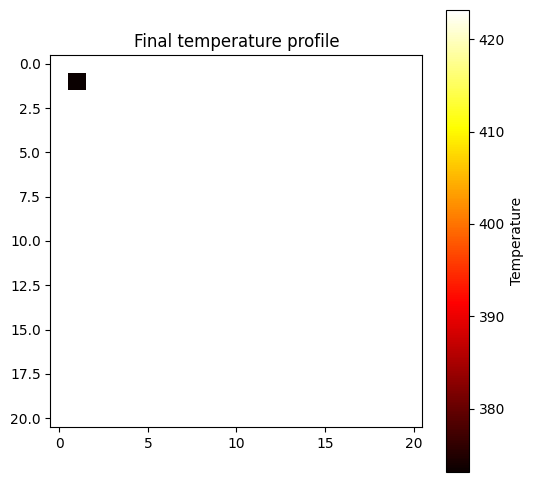

In [764]:
import numpy as np

np.set_printoptions(precision=15)

# Solution numérique

# Initialiser le profil de température à T0
T = np.full((nx+1, ny+1), T0)

# # Appliquer les conditions aux limites initiales
# T[0, :] = T[1, :] # x = 0, isolation thermique
# T[:, 0] = T[:, 1] # y = Ly, isolation thermique
# T[-1, :] = T1  # y = 0, conduction
# T[:, -1] = T[:, -2] - h* (T[:, -2] - Ta) * dx / k # x = Lx, convection

# print(T)

# Exécuter la méthode ADI
T_numerical = ADI_method(T)
# T[:, -1] = (2*dx*h*Ta + k*T[:, -2]) / (2*dx*h + k) # x = Lx, convection
# T[:, -1] = T[:, -2] - h * (T[:, -2] - Ta) * dx / k # x = Lx, convection
# print(T)
# Créer la figure en dehors de la boucle
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(T_numerical, cmap='hot', interpolation='nearest')
colorbar = fig.colorbar(im, ax=ax)
colorbar.set_label('Temperature')
ax.set_title(f"Final temperature profile")    
plt.show()  
# Display the plot

# print(T)

[0.7869799961174745, 3.371602584434392, 6.40581032937165, 9.507623760332303, 12.628803108527745, 15.758021212592112, 18.891321901867013, 22.026974461931456, 25.164103951638275, 28.30222105821236, 31.441030923507324, 34.580345351496426, 37.720038609468176, 40.860023513078744, 44.000237711998565, 47.14063543915099, 50.281182343189265, 53.42185213931088, 56.5626243734645, 59.7034828909423, 62.84441476341884, 65.98540952197548, 69.12645859893777, 72.26755491510053, 75.40869256998845, 78.54986660636392, 81.69107282905608, 84.83230766388878, 87.97356804694749, 91.11485133665927, 94.25615524344107, 97.39747777297312, 100.53881718010265, 103.68017193109335, 106.82154067257255, 109.96292220577003, 113.10431546505552, 116.24571949995781, 119.38713346001911, 122.52855658199174, 125.66998817888516, 128.81142763073154, 131.95287437663083, 135.09432790779744, 138.23578776169265, 141.377253516895, 144.51872478861043, 147.6602012247879, 150.80168250270674, 153.9431683259857, 157.08465842194758, 160.22

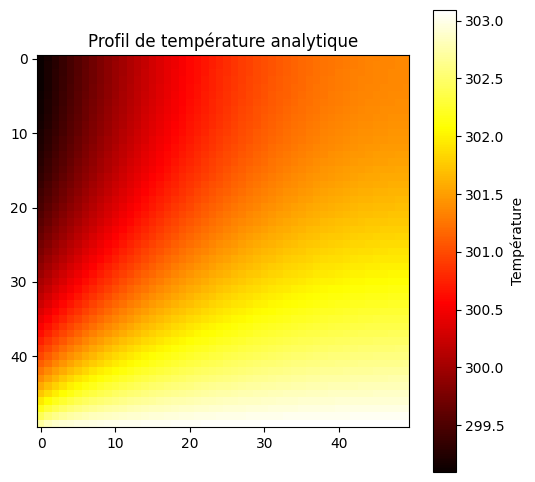

In [ ]:
# Solution analytique
n_solutions = 100
liste_solutions = find_first_n_solutions(Lx, h, k, n_solutions)
print(liste_solutions)

T_analytical = generate_analytical_profile(nx, ny, Lx, Ly, T1, Ta, h, k, 90, liste_solutions)

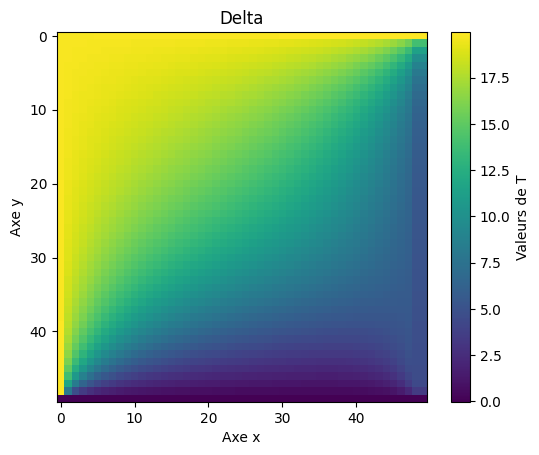

In [ ]:
# Comparison
Delta = T_analytical - T_numerical
# print(T_analytical)
# print(T_numerical)
# print(Delta)
# print(Delta)

plt.imshow(Delta)
plt.colorbar(label='Valeurs de T')
plt.xlabel('Axe x')
plt.ylabel('Axe y')
plt.title('Delta')
plt.show()